In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels as sts

In [2]:
df_psy = pd.read_csv('df_psy.csv')
df_appr = pd.read_csv('df_appr.csv')
df_spec = pd.read_csv('df_spec.csv')

In [3]:
df_young = df_psy[df_psy['Возраст (в годах)'] <= 33]
df_middle = df_psy[(33 < df_psy['Возраст (в годах)'])  & (df_psy['Возраст (в годах)'] <= 44)]
df_old = df_psy[df_psy['Возраст (в годах)'] > 44]

# Проверяем гипотезы
1. Среди молодых психологов есть следующая зависимость: чем больше опыт работы, тем больше стоимость за сессию
2. Если психолог входит в группу 34-44 года и работает с подростками 11-15 лет, то он еще работает либо с подростками 16-18 лет, либо с детьми 3-10 лет.
6. Если психолог использует ССТ, то его широта подхода выше, чем у тех, кто его не использует.
4. Если у психолога на странице загружено видеоприветствие, то его цена ниже, чем у тех, у кого не загружена.
3. Пол не влияет на стоимость сессии.
5. Если психолог квир-френдли, то его цена выше, чем у тех, кто не квир-френдли

## Гипотеза 1
Если психолог молодой (до 33 лет), то чем больше его опыт работы, тем больше стоимость за сессию.

$$
    H_0: \rho \leq 0\\
    H_a : \rho > 0
$$
где $\rho$ -- коэффициент корреляции.

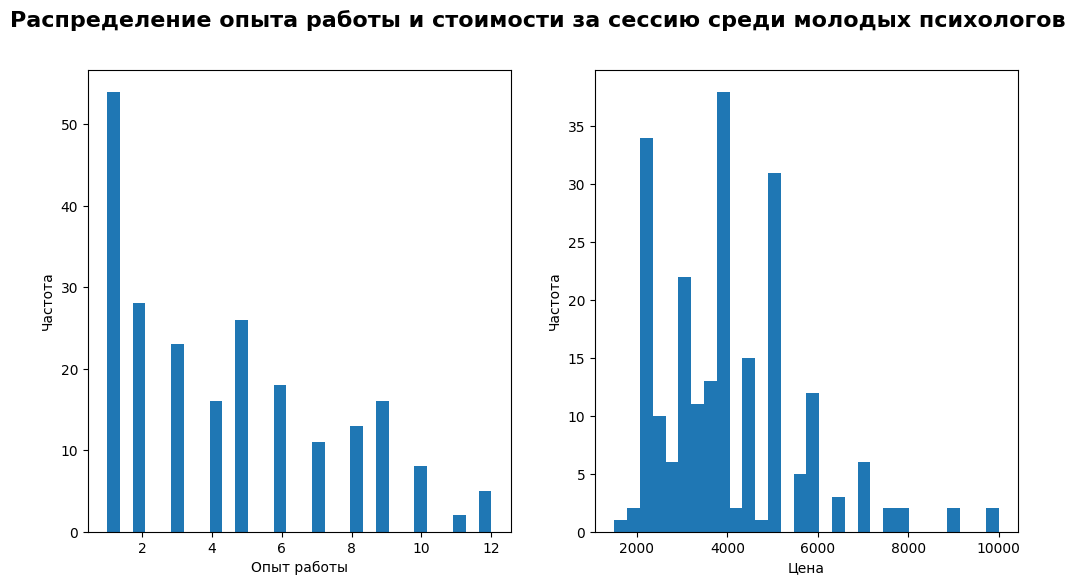

In [44]:
f, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
axes[0].hist(df_young['Опыт работы (в годах)'], bins = 30)
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Опыт работы')

axes[1].hist(df_young['Цена за сессию (руб)'], bins = 30)
axes[1].set_ylabel('Частота')
axes[1].set_xlabel('Цена')
plt.suptitle('Распределение опыта работы и стоимости за сессию среди молодых психологов', size = 16, fontweight = 'bold')
plt.show()

In [5]:
df_young.shape

(220, 26)

Чисто с гистограмм видно, что данные распределены не нормально, будем использовать корреляцию по Спирману, а не по Пирсону.

In [ ]:
corr, p_value = stats.spearmanr(df_young['Опыт работы (в годах)'], df_young['Цена за сессию (руб)'])
print(f'Коэффициент корреляции Спирмена: {corr:.3f}, p-value: {p_value:.5f}')

Коэффициент корреляции Спирмена: 0.801, p-value: 0.00000


p-value < 0.05 $\Rightarrow$ Нулевая гипотеза отвергается (связь между параметрами статистически значимая), при этом коэффициент корреляции > 0.5, то есть связь сильная. **Если психолог молодой (до 33 лет), то чем больше его опыт работы, тем больше стоимость за сессию.**

## Гипотеза 2

Если психолог среднего возраста (от 34 до 44 лет), то если он работает с подростками 11-15 лет, то он также работает либо с детьми 3-10 лет, либо с подростками 16-18 лет

$$
H_0:\text{ Работа психолога с подростками 11-15 лет не влияет на работу с другими группами}\\
H_a:\text{ Работа психолога с подростками 11-15 лет влияет на работу с другими группами}
$$

In [39]:
c1 = pd.crosstab(
    df_middle['Группа: Подростки от 16 до 18 лет'],
    df_middle['Группа: Подростки от 11 до 15 лет']
)
c2 = pd.crosstab(
    df_middle['Группа: Дети от 3 до 10 лет'],
    df_middle['Группа: Подростки от 11 до 15 лет']
)


chi2_1, p_1, foo1, foo2 = stats.chi2_contingency(c1)
print(f"Хи-квадрат (16-18 и 11-15 лет): {chi2_1:.3f}, p-value: {p_1:.5f}")

chi2_2, p_2, foo1, foo2 = stats.chi2_contingency(c2)
print(f"Хи-квадрат (3-10 и 11-15 лет): {chi2_2:.3f}, p-value: {p_2:.5f}")

Хи-квадрат (16-18 и 11-15 лет): 268.813, p-value: 0.00000
Хи-квадрат (3-10 и 11-15 лет): 102.184, p-value: 0.00000


p-value < 0.05 ⇒ Нулевая гипотеза отвергается, влияние на работу с группами "3-10 лет" и "16-18 лет" есть от работы с группами "11-15 лет".

In [40]:
def cramers_v(chi2, n, min_dim):
    return np.sqrt(chi2 / (n * (min_dim - 1)))

n = len(df_middle)
min_dim_1 = min(c1.shape)
min_dim_2 = min(c2.shape)

cramer_v1 = cramers_v(chi2_1, n, min_dim_1)
cramer_v2 = cramers_v(chi2_2, n, min_dim_2)

print(f"Значимость (16-18 и 11-15 лет): {cramer_v1:.3f}")
print(f"Значимость(3-10 и 11-15 лет): {cramer_v2:.3f}")

Значимость (16-18 и 11-15 лет): 0.782
Значимость(3-10 и 11-15 лет): 0.482


Значимость зависимости "11-15 лет" и "16-18 лет" высокая (>0.5), а значимость зависимости "3-10 лет" и "11-15 лет" умеренная (<0.5).

## Гипотеза 3
Если психолог практикует ССТ, то его ширина подхода в серднем больше, чем у тех, кто его не практикует
$$
H_0: \mu_{sst} = \mu_{non-sst}\\
H_a: \mu_{sst} > \mu_{non-sst}
$$
Где $\mu$ - среднее значение ширины подхода

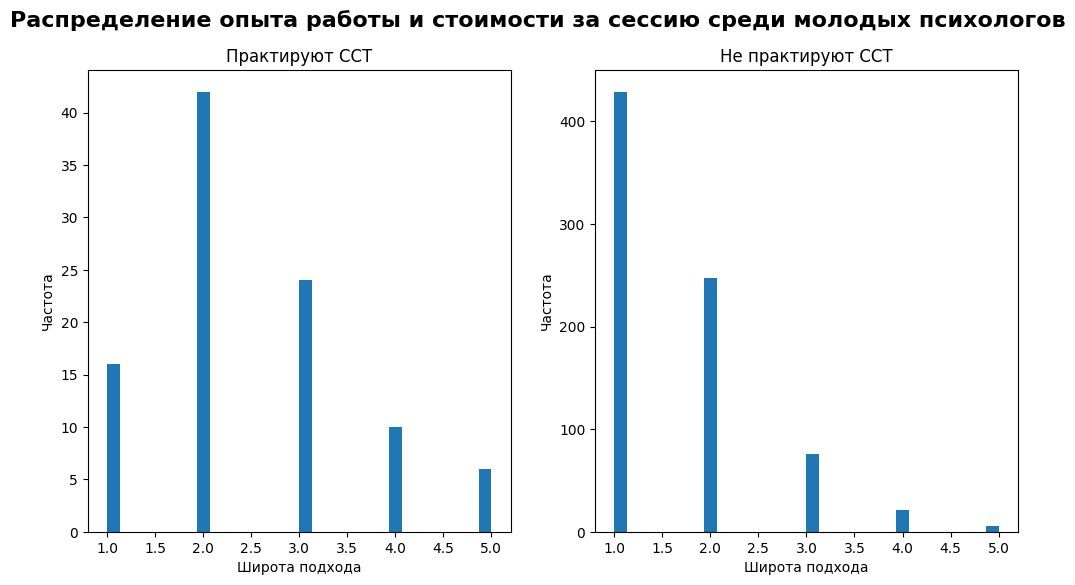

In [43]:
sst = df_appr[df_appr['Подход: ССТ'] == 1]['Широта подхода']
nsst = df_appr[df_appr['Подход: ССТ'] == 0]['Широта подхода']
f, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
axes[0].hist(sst, bins = 30)
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Широта подхода')
axes[0].set_title('Практируют ССТ')

axes[1].hist(nsst, bins = 30)
axes[1].set_ylabel('Частота')
axes[1].set_xlabel('Широта подхода')
axes[1].set_title('Не практируют ССТ')
plt.suptitle('Распределение опыта работы и стоимости за сессию среди молодых психологов', size = 16, fontweight = 'bold')
plt.show()

In [9]:
sst.shape[0], nsst.shape[0]

(98, 779)

Можно использовать асимптотический z-тест (Данные не нормальны *(crazy)*, больше 30 наблюдений в каждой группе, ЦПТ работает)

In [11]:
alpha = 0.05                                       # уровень значимости = 5%
n1,n2 = sst.size, nsst.size                      # размеры выборок

p1, p2 = sst.mean(), nsst.mean()               # точеные оценки долей
diff = p1 - p2                                     # разность долей

diff_std = np.sqrt(sst.var(ddof=1)/n1 + nsst.var(ddof=1)/n2)

z_obs = diff/diff_std                              # наблюдаемое значение статистики
z_crit = stats.norm.ppf(1 - alpha)               # критическое значение статистики, одностороннее

print(f'{z_obs:.3} не попадает в ({-z_crit:.3} , {z_crit:.3}) => Нулевая гипотеза отвергается, если психолог практикует ССТ, то он использует больше подходов.')

7.5 не попадает в (-1.64 , 1.64) => Нулевая гипотеза отвергается, если психолог практикует ССТ, то он использует больше подходов.


**Нулевая гипотеза отвергается, если психолог практикует ССТ, то он использует больше подходов.**

## Гипотеза 4
Если у психолога загружено видеоприветствие, то его стоимость сессии ниже, чем у тех, у кого не загружено.

$$
H_0: \mu_{vid} = \mu_{non-vid}\\
H_a: \mu_{vid} < \mu_{non-vid}
$$
Где $\mu$ - среднее значение цены за сессию.

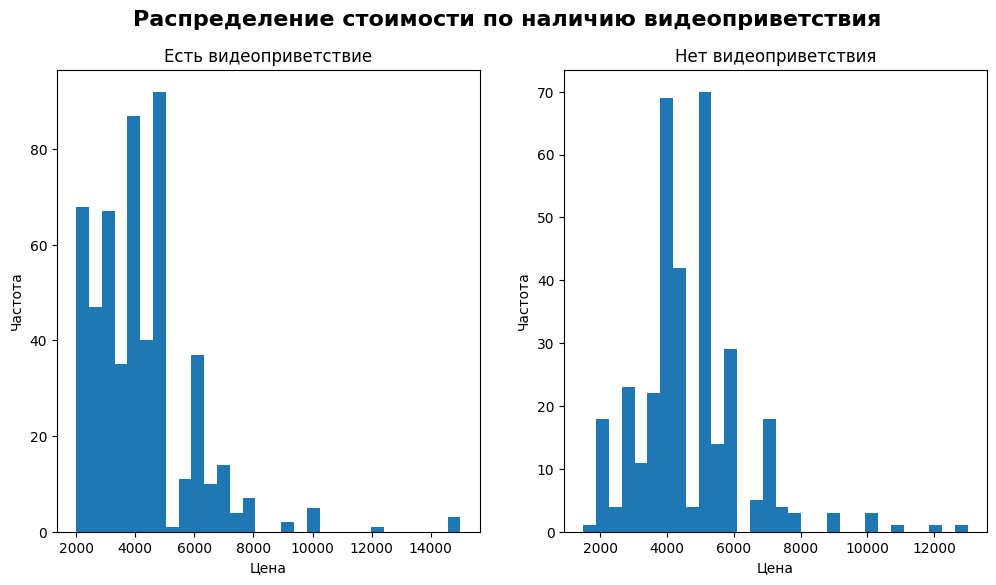

In [42]:
vid = df_psy[df_psy['Наличие видеоприветствия'] == 1]['Цена за сессию (руб)']
nvid =  df_psy[df_psy['Наличие видеоприветствия'] == 0]['Цена за сессию (руб)']
f, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
axes[0].hist(vid, bins = 30)
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Цена')
axes[0].set_title('Есть видеоприветствие')

axes[1].hist(nvid, bins = 30)
axes[1].set_ylabel('Частота')
axes[1].set_xlabel('Цена')
axes[1].set_title('Нет видеоприветствия')
plt.suptitle('Распределение стоимости по наличию видеоприветствия', size = 16, fontweight = 'bold')
plt.show()

Данные даже по гистограммам уже не очень нормальные, давайте для разнообразия поанализируем непараметрическим U-тестом Манна-Уитни.

In [17]:
u_stat, p_value = stats.mannwhitneyu(vid, nvid, alternative='less')
print(f"u-stat = {u_stat}, p-value < 0.05: {p_value<0.05} => Нулевая гипотеза отвергается, у психолога с видеоприветствием стоимость за сессию ниже, чем у психологов без видеоприветствия")

u-stat = 72910.0, p-value < 0.05: True => Нулевая гипотеза отвергается, у психолога с видеоприветствием стоимость за сессию ниже, чем у психологов без видеоприветствия


**Нулевая гипотеза отвергается**, у психологов с видеоприветствием стоимость за сессию в среднем ниже, чем у психологов без него.

## Гипотеза 5
Пол не влияет на стоимость сессии
$$
    H_0: \mu_w = \mu_m\\
    H_a : \mu_w \neq \mu_m
$$
где $\mu$ - среднее значение цены за сессию.

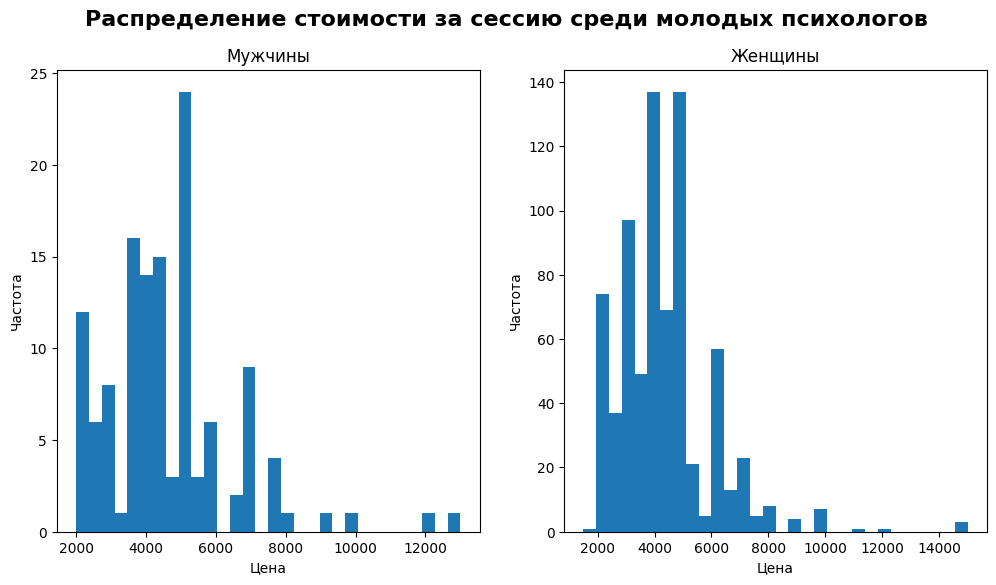

In [41]:
m, w = df_psy[df_psy['Пол'] == 1]['Цена за сессию (руб)'], df_psy[df_psy['Пол'] == 0]['Цена за сессию (руб)']

f, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
axes[0].hist(m, bins = 30)
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Цена')
axes[0].set_title('Мужчины')
axes[1].hist(w, bins = 30)
axes[1].set_ylabel('Частота')
axes[1].set_xlabel('Цена')
axes[1].set_title('Женщины')
plt.suptitle('Распределение стоимости за сессию среди молодых психологов', size = 16, fontweight = 'bold')
plt.show()

Графики не сильно похожи на нормальные, но проведем дополнительный тест Колмогорова-Смирнова и проверим гипотезу о нормальности распределения.

In [ ]:
stats.kstest(m, 'norm', args=(m.mean(), m.std(ddof=1))), stats.kstest(w, 'norm', args=(w.mean(), w.std(ddof=1)))

(KstestResult(statistic=0.1890332568995915, pvalue=0.00017691767624990667, statistic_location=5000, statistic_sign=1),
 KstestResult(statistic=0.15337591840595233, pvalue=7.510742498783546e-16, statistic_location=5000, statistic_sign=1))

Подтвердили, данные не нормальные (crazyyy again), их достаточно много, будем использовать ассимптотический z-тест

In [ ]:
alpha = 0.05                                       # уровень значимости = 5%
n1,n2 = w.size, m.size                      # размеры выборок

p1, p2 = w.mean(), m.mean()               # точеные оценки долей
diff = p1 - p2                                     # разность долей

diff_std = np.sqrt(w.var(ddof=1)/n1 + m.var(ddof=1)/n2)

z_obs = diff/diff_std                              # наблюдаемое значение статистики
z_crit = stats.norm.ppf(1 - alpha/2)               # критическое значение статистики

print(f'{z_obs:.3} попадает в ({-z_crit:.3} , {z_crit:.3}) => Нулевая гипотеза не отвергается, пол не влияет на стоимость сессии.')

-1.58 попадает в (-1.96 , 1.96) => Нулевая гипотеза не отвергается, пол не влияет на стоимость сессии.


##Гипотеза 6
Если психолог квир-френдли, то его цена выше, чем у тех, кто не квир-френдли


$$
    H_0: \mu_{q} = \mu_{nq}\\
    H_a : \mu_{q} > \mu_{nq}
$$
Где $\mu$ - среднее значение цены за сессию.

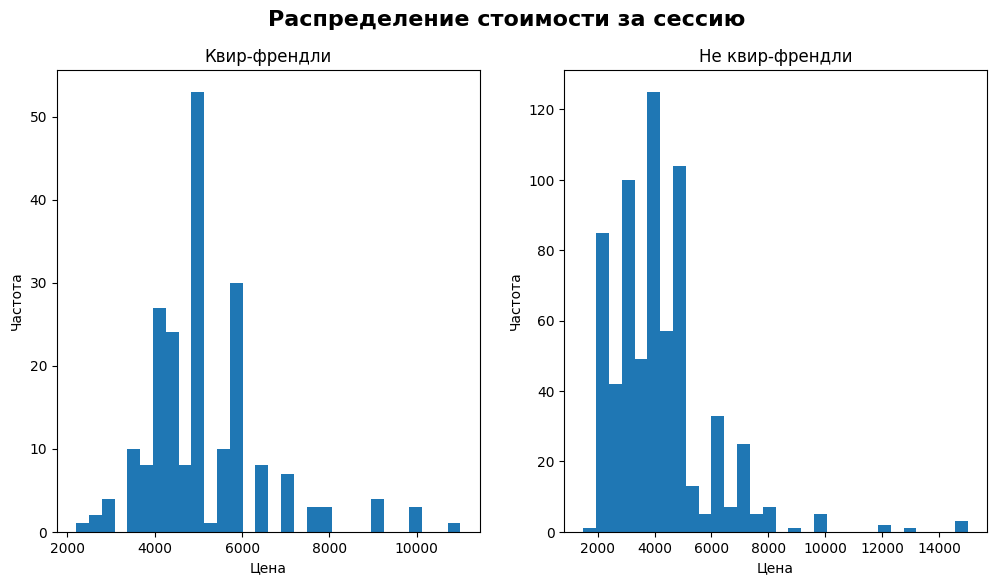

In [18]:
q, nq = df_psy[df_psy['Квир-френдли'] == 1]['Цена за сессию (руб)'], df_psy[df_psy['Квир-френдли'] == 0]['Цена за сессию (руб)']

f, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
axes[0].hist(q, bins = 30)
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Цена')
axes[0].set_title('Квир-френдли')
axes[1].hist(nq, bins = 30)
axes[1].set_ylabel('Частота')
axes[1].set_xlabel('Цена')
axes[1].set_title('Не квир-френдли')
plt.suptitle('Распределение стоимости за сессию', size = 16, fontweight = 'bold')
plt.show()

Удивительно, но факт: данные все еще не очень нормальные (тест Колмогорова-Смирнова подтверждает, отвергаем нулевую гипотезу о нормальности), выборки достаточно большие для работы ЦПТ, используем асимптотический z-тест

In [22]:
stats.kstest(q, 'norm', args=(m.mean(), m.std(ddof=1))), stats.kstest(nq, 'norm', args=(w.mean(), w.std(ddof=1)))

(KstestResult(statistic=0.24452510870899646, pvalue=2.2014882705402912e-11, statistic_location=4000, statistic_sign=-1),
 KstestResult(statistic=0.19127122159627574, pvalue=6.096121801561018e-22, statistic_location=5000, statistic_sign=1))

In [24]:
q.size, nq.size

(207, 670)

In [27]:
alpha = 0.05                                       # уровень значимости = 5%
n1,n2 = q.size, nq.size                      # размеры выборок

p1, p2 = q.mean(), nq.mean()               # точеные оценки долей
diff = p1 - p2                                     # разность долей

diff_std = np.sqrt(q.var(ddof=1)/n1 + nq.var(ddof=1)/n2)

z_obs = diff/diff_std                              # наблюдаемое значение статистики
z_crit = stats.norm.ppf(1 - alpha)               # критическое значение статистики (проводим односторонний тест)

print(f'{z_obs:.3} не попадает в ({-z_crit:.3} , {z_crit:.3}) => Нулевая гипотеза отвергается, то, что психолог квир-френдли, влияет на цену.')

8.44 не попадает в (-1.64 , 1.64) => Нулевая гипотеза отвергается, то, что психолог квир-френдли, влияет на цену.


**Нулевая гипотеза отвергается**, у квир-френдли психологов цены выше, чем у не френдли-психологов